<a href="https://colab.research.google.com/github/Krahjotdaan/MachineLearning/blob/main/BaggingClassifier_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Композиция алгоритмов


In [ ]:
import pandas as pd
import numpy as np
from random import randrange
import math
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Практика 1
### Шаг 1 - Загружаем данные

In [ ]:
cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [ ]:
y = df['target']
X = df.drop(columns=['target'])

In [ ]:
X.shape

(569, 30)

In [ ]:
y.value_counts()

1.0    357
0.0    212
Name: target, dtype: int64


### Шаг 2 - Строим решающее дерево и получаем оценку правильности

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y, scoring='f1_macro').mean()

0.9100916329159305


### Шаг 3 - Реализуем bagging (bootstrapaggregation)
- опишите класс с параметрами:
    - estimators - список алгоритмов
    - n_estimators - кол-во обучаемых алгоритмов
    - sample_size (по умолчанию 1.0) -  доля объектов в подвыборке
    - n_features - кол-во признаков в подпространстве
- и методами:
     - predict() - возвращает матрицу, элемент которой есть a[i,j] - ответ i-го алгоритма на j-м объекте
     - fit() - обученный алгоритм должен оказаться в списке estimators
- проверьте реализацию класса на приведенной ниже ячейки

In [ ]:
class BaggingDecisionClassifier:
    def __init__(self, n_estimators, sample_size = 1.0):
        self.n_estimators = n_estimators
        self.sample_size = sample_size
        self.estimators = []


    def bootstrap_samples(self, data_size):
      indexes = []

      while len(indexes) < data_size * self.sample_size:
        indexes.append(randrange(data_size))

      return np.array(indexes)


    def predict(self, X):

        predicted = np.zeros((self.n_estimators, len(X)))

        for i, alg, in enumerate(self.estimators):
          y_pred = alg.predict(X)

          for j, v in enumerate(y_pred):
            predicted[i][j] = v

        result = []

        for j in range(len(X)):
          column = predicted[:, j]
          result.append(sum(column) / len(column) > 0.5)

        return np.array(result)


    def fit(self, X, y):
        for i in range(self.n_estimators):
          indexes = self.bootstrap_samples(len(X))

          X_samples = X.iloc[indexes]
          y_samples = y.iloc[indexes]

          tree = DecisionTreeClassifier()
          tree.fit(X_samples, y_samples)

          self.estimators.append(tree)


In [ ]:
# ПРОВЕРКА реализации класса
bcf = BaggingDecisionClassifier(n_estimators=10)
bcf.fit(X, y)
y_pred = bcf.predict(X)
accuracy_score(y, y_pred)

0.9982425307557118


### Шаг 4 - Используем BaggingDecisionClassifier
- разбейте данные на обучение и тест, в тест положите третью часть данных
- обучите BaggingDecisionClassifier
- постройте прогноз  на тесте
- посчитайте accuracy

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
bcf = BaggingDecisionClassifier(n_estimators=10)
bcf.fit(X_train, y_train)
y_pred = bcf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6436170212765957


### Шаг 5 - Сравниваем с BaggingClassifier
- обучите библиотечную модель
- оптимизируйте параметры с помощью решетчатого поиска:
    - n_estimators - количество базовых алгоритмов
    - max_features - количество отбираемых для обучения признаков
    - base_estimator - по умолчанию DecisionTreeClassifier
    - max_depth для  DecisionTreeClassifier - глубина дерева

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
tree = DecisionTreeClassifier()
cross_val_score(BaggingClassifier(tree, 20, max_samples=0.9), X, y, scoring='f1_macro').mean()

0.9552531443460837

#  Алгоритм случайного леса


## Практика 2
### Шаг 3.1 - Загружаем данные для задачи


In [ ]:
from sklearn.datasets import load_digits

dataset = load_digits()

X = dataset['data']
y = dataset['target']

In [ ]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

Text(0.5, 1.0, 'Label: 0')

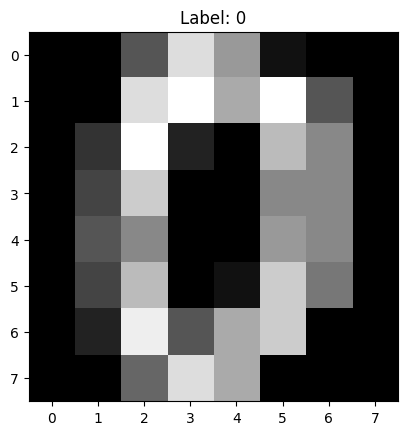

In [ ]:
plt.imshow(X[0].reshape(8, 8), cmap='gist_gray')
plt.title('Label: {}'.format(y[0]))


### Шаг 3.2 - Сравниваем классификаторы и ансамбли

Для кросс-валидации на 5ти фолдах с параметрами по умолчанию обучите:

- алгоритм ближайших соседей
- решающее дерево
- беггинг
- случайный лес

Сравните все алгоритмы по метрике accuracy


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
cross_val_score(KNeighborsClassifier(), X, y).mean()

0.9627282575054161

In [ ]:
cross_val_score(BaggingClassifier(DecisionTreeClassifier()), X, y).mean()

0.8781600123800681

In [ ]:
cross_val_score(BaggingClassifier(KNeighborsClassifier()), X, y).mean()

0.9627298050139276

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y).mean()

0.7880269266480966

In [ ]:
cross_val_score(RandomForestClassifier(), X, y).mean()

0.9371386567626121

In [ ]:
cross_val_score(LogisticRegression(solver='liblinear'), X, y).mean()

0.9221138966264315

# Важная деталь из документации про max_features

Для BaggingClassifier

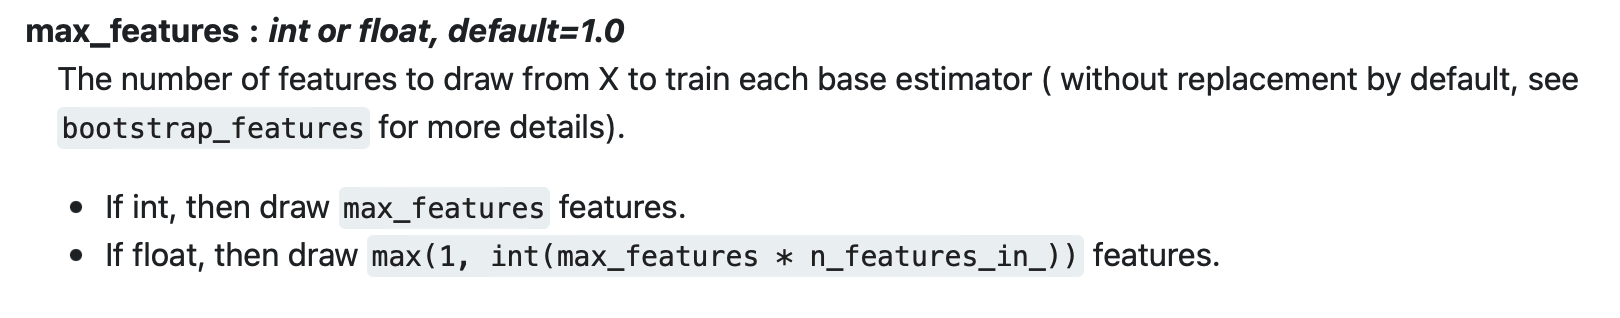

Для RandomForestClassifier

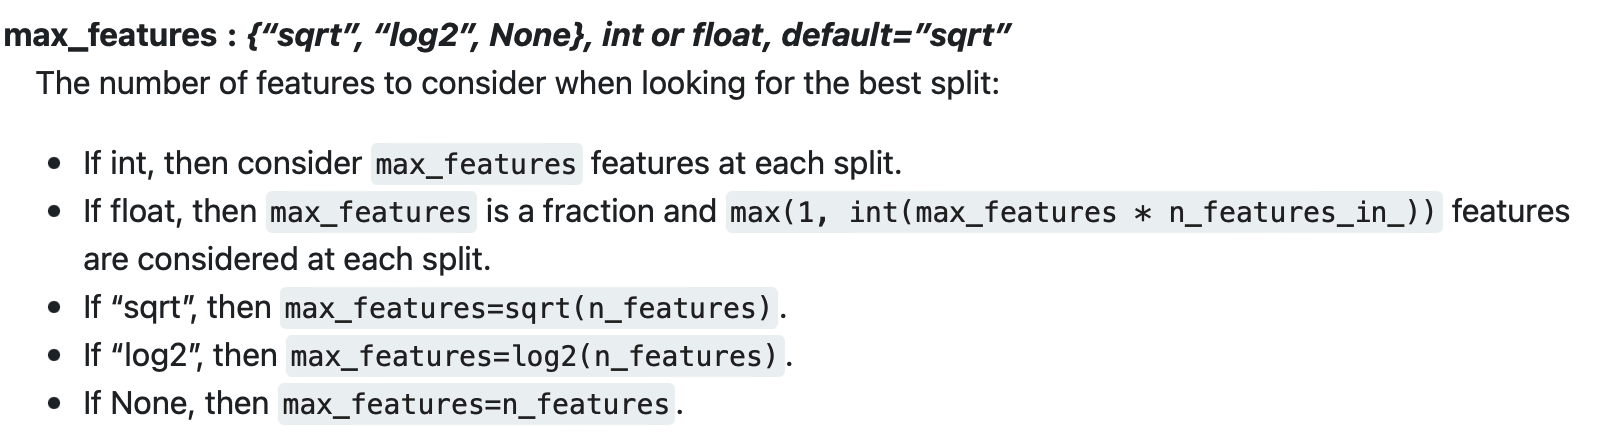

## Практика 4

*Во всех задачах имеется в виду cross_val_score на случайном лесе.*

### Задача 4.1
Постройте график cross_val_score от количества деревьев.

n_estimators (1, 150) шаг равный 5


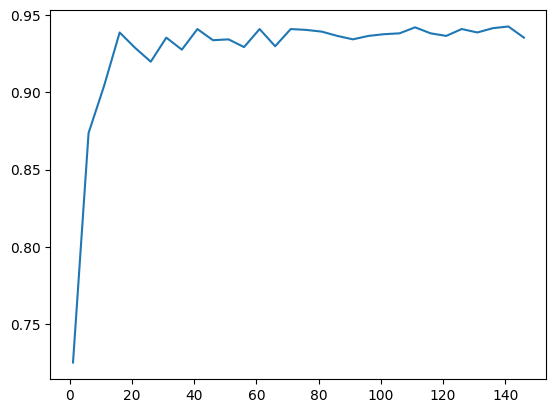

In [ ]:
y_range = []
for i in range(1, 150, 5):
  y_range.append(cross_val_score(RandomForestClassifier(n_estimators=i), X, y).mean())

plt.plot(range(1, 150, 5), y_range);

### Задача 4.2
Постройте график cross_val_score от количества фич.

max_features = (1..N features)

используйте 50/100 деревьев (в зависимости от скорости выполнения)

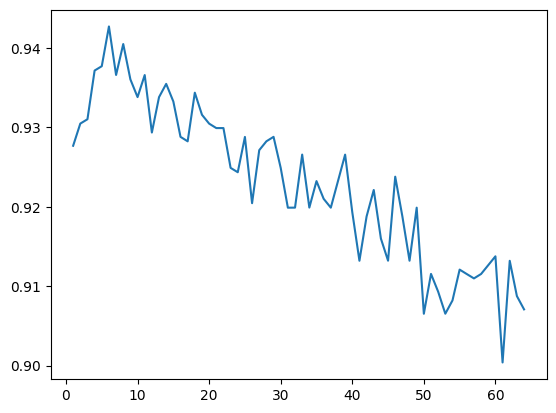

In [ ]:
y_range = []
for i in range(1, 65):
  y_range.append(cross_val_score(RandomForestClassifier(n_estimators=50, max_features=i), X, y).mean())

plt.plot(range(1, 65), y_range);

### Задача 4.3

Постройте график cross_val_score от глубины дерева.


max_depth = (1..30)

используйте 50/100 деревьев(в зависимости от скорости), постройте 2 графика:

max_features = n

max_features = 'sqrt'

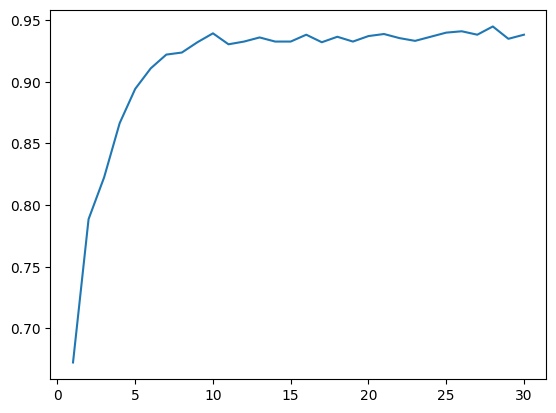

In [ ]:
y_range = []
for i in range(1, 31):
  y_range.append(cross_val_score(RandomForestClassifier(n_estimators=50, max_depth=i), X, y).mean())

plt.plot(range(1, 31), y_range);

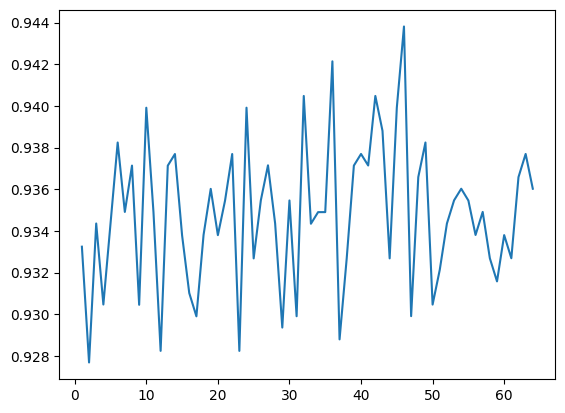

In [ ]:
y_range = []
for i in range(1, 65):
  y_range.append(cross_val_score(RandomForestClassifier(n_estimators=50, max_features='sqrt'), X, y).mean())

plt.plot(range(1, 65), y_range);

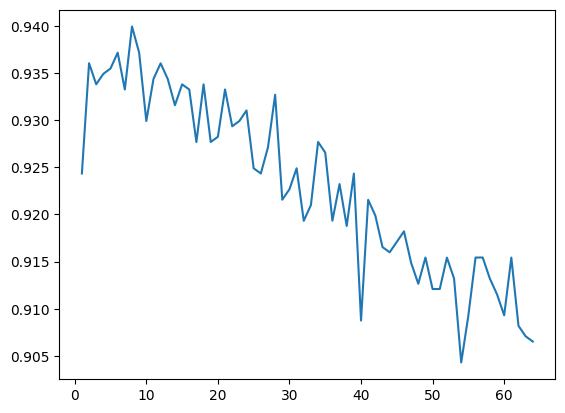

In [ ]:
y_range = []
for i in range(1, 65):
  y_range.append(cross_val_score(RandomForestClassifier(n_estimators=50, max_features=i), X, y).mean())

plt.plot(range(1, 65), y_range);